In this notebook:
1. Get county demographic data: 
    + county_demographics_df.csv
    + jail_county_demographics_df.csv (jail_county_df.csv + county_demographics_df.csv)
2. county clustering
    + simple k-means

In [158]:
library('tidyverse')
library('repr')
library('factoextra')

In [161]:
# load datasets

# --------------
# from jessica:
# jail_county_df, without the index column X
jail_county_df <- read.csv('jail_county_df.csv', stringsAsFactors = FALSE)[ , 2:10]

# prison_county_df, without the index column X
prison_county_df <- read.csv('prison_county_df.csv', stringsAsFactors = FALSE)[ , 2:7]
#  capitalize county name:
prison_county_df$county <- str_to_title(prison_county_df$county)

# nytimes
us_counties <- read.csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
# vera inst
#jail_population <- read.csv('https://raw.githubusercontent.com/vera-institute/jail-population-data/master/jail_population.csv')


# merge with demographics datasets

# --------------
# county demographics: 
#   https://github.com/ringhilterra/enriched-covid19-data
county_demographics_df <- read.csv('https://raw.githubusercontent.com/ringhilterra/enriched-covid19-data/master/us_county_demographics.csv', stringsAsFactors = FALSE)

#  tidy up column names: convert to lower case
names(county_demographics_df) <- str_to_lower(names(county_demographics_df))
#  remove word "county" from county column
county_demographics_df$county <- sub(county_demographics_df$county, pattern = " [[:alpha:]]*$", replacement = "")

# -------------- 
# clean up county_demographic_df
#  note: county populations from this dataset is similar but not the same as nytimes/vera inst.
#   We'll use just the other columns (race/ethnicity, age, gender, etc.)
county_demographics_df <- county_demographics_df[ , c(4, 3, 5:21)]
            
# compute age group percentages instead of count, and
#  add lowrisk_agegroup_perc and highrisk_agegroup_perc columns:
county_demographics_df <- county_demographics_df %>%
    mutate(age_oto4_perc = age_oto4/tot_pop,
          age_5to14_perc = age_5to14/tot_pop,
          age_15to24_perc = age_15to24/tot_pop,
          age_25to34_perc = age_25to34/tot_pop,
          age_35to44_perc = age_35to44/tot_pop,
          age_45to54_perc = age_45to54/tot_pop,
          age_55to64_perc = age_55to64/tot_pop,
          age_65to74_perc = age_65to74/tot_pop,
          age_75to84_perc = age_75to84/tot_pop,
          age_84plus_perc = age_84plus/tot_pop,
          'lowrisk_agegroup_perc' = rowSums(. [10:16])/tot_pop ,
          'highrisk_agegroup_perc' = rowSums(. [17:19])/tot_pop)   
# remove age group count:
#  (note: resident_population (from vera inst) and tot_pop columns are close but not equal)
county_demographics_df <- county_demographics_df[ , c(1:9, 20:31)]

# ---------------
# county land area and population data
# from https://github.com/ykzeng/covid-19/tree/master/data
landarea <- read.csv('https://raw.githubusercontent.com/ykzeng/covid-19/master/data/census-population-landarea.csv')

# use nytimes to get fip-county key
fips_county <- us_counties %>% 
    group_by(county, state, fips) %>%
    summarize( dummy = 1)
fips_county <- fips_county[ , 1:3]

# --------------
# join landarea and fips_county to get landarea information for each county
landarea_county <- left_join( landarea, fips_county, by="fips")

#take only column LND110210
landarea_county <- landarea_county[, c(8, 9, 6) ]
# rename column LND110210 to land_area
names(landarea_county)[3] <- 'land_area'

# --------------
# join demographics + landarea datasets
county_demographics_df <- left_join(county_demographics_df, landarea_county, by=c("county", "state"))
# add a population density column
county_demographics_df <- county_demographics_df %>% 
    mutate(population_density = tot_pop / land_area )

# --------------
# join jessica's jail dataset + (demographics + landarea) datasets
jail_county_demographics_df <- full_join( jail_county_df, county_demographics_df, by = c('county', 'state')) 

# add infection rate column
jail_county_demographics_df <- jail_county_demographics_df %>%
    mutate( pop_infection_rate = cases/resident_population )

Warning message:
"Column `county` joining character vector and factor, coercing into character vector"Warning message:
"Column `state` joining character vector and factor, coercing into character vector"

In [164]:
head(county_demographics_df, 3)
#write.csv(county_demographics_df, 'county_demographics_df.csv')

county,state,tot_pop,male_perc,female_perc,white_pop_perc,black_pop_perc,asian_pop_perc,hisp_pop_perc,age_oto4_perc,...,age_35to44_perc,age_45to54_perc,age_55to64_perc,age_65to74_perc,age_75to84_perc,age_84plus_perc,lowrisk_agegroup_perc,highrisk_agegroup_perc,land_area,population_density
Autauga,Alabama,55601,0.4855129,0.5144871,0.7837989,0.20616536,0.017301847,0.02965774,0.06050251,...,0.1302854,0.1398716,0.1288466,0.08812791,0.05183360,0.01566519,0.8443733,0.1556267,594.44,93.53509
Baldwin,Alabama,218022,0.4846162,0.5153838,0.8895983,0.09688472,0.015613103,0.04646779,0.05483392,...,0.1194054,0.1316519,0.1440634,0.12263900,0.06205337,0.01974113,0.7955665,0.2044335,1589.78,137.13973
Barbour,Alabama,24881,0.5278325,0.4721675,0.5003416,0.49290623,0.006068888,0.04276355,0.05160564,...,0.1198103,0.1296974,0.1290543,0.11563040,0.05960371,0.01897030,0.8057956,0.1942044,884.88,28.11794


### Filter by state, date

In [165]:
# filter jail_county_demographics_df 

#  consider only some states
selected_states <- 'California|Texas|Ohio|Oregon'
jail_county_demographics_filtered_df <- jail_county_demographics_df %>%
    filter( #grepl( selected_states, state) ,   # use all states
          jail_incarceration_rate_per_100k < 2000 ) # remove outlier counties



#  keep most recent data
jail_county_demographics_filtered_df$date <- as.Date(jail_county_demographics_filtered_df$date)

jail_county_demographics_filtered_df <- jail_county_demographics_filtered_df %>%
    group_by(county) %>% 
    filter(date == max(date))

Warning message:
"Removed 8 rows containing missing values (geom_point)."

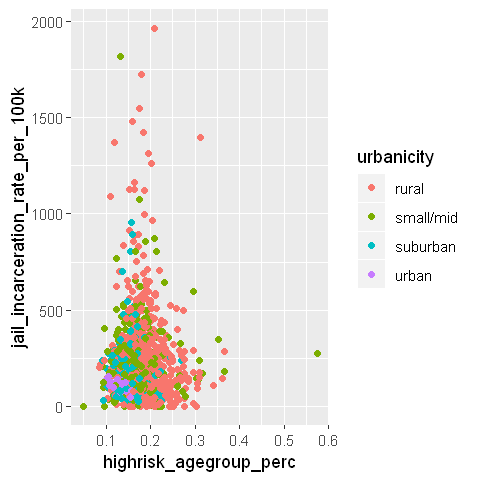

In [166]:
# try some plots
options(repr.plot.width=4, repr.plot.height=4)
ggplot(jail_county_demographics_filtered_df, 
       aes( x = highrisk_agegroup_perc, y = jail_incarceration_rate_per_100k, color = urbanicity) ) + 
            geom_point()

## k-means clustering + project to 2 principal components to visualize

In [167]:
# column names
#jail_county_demographics_columns <- data.frame( colindex = 1:31, colname = names(jail_county_demographics_df))
jail_county_demographics_columns

#county_demographics_columns <- data.frame( colindex = 1:23, colname = names(county_demographics_df))
#county_demographics_columns

colindex,colname
1,date
2,county
3,state
4,jail_population
5,resident_population
6,cases
7,deaths
8,jail_incarceration_rate_per_100k
9,urbanicity
10,tot_pop


cluster,count,ave_incarceration_rate,ave_jail_pop,ave_res_pop,ave_highrisk_agegroup_perc
1,788,232.42284,161.4657,94271.12,0.1829725
2,15,95.06667,3024.5333,2828677.53,0.1447733
3,168,280.87440,383.6488,230430.54,0.1671051


cluster,urbanicity,count,ave_incarceration_rate,ave_res_pop,ave_highrisk_agegroup_perc
1,rural,432,259.1706,31973.31,0.1935420
1,small/mid,242,205.3281,153191.85,0.1758847
1,suburban,109,191.7917,164340.42,0.1599914
1,urban,5,118.5600,1097528.40,0.1138086
2,suburban,5,73.9600,1362795.60,0.1589736
2,urban,10,105.6200,3561618.50,0.1376732
3,rural,68,339.0382,31351.25,0.1847879
3,small/mid,60,292.9233,168234.65,0.1655664
3,suburban,27,185.2815,355611.15,0.1383516
3,urban,13,119.5615,1298835.85,0.1414309


Importance of components:
                         PC1    PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     2.851 2.0795 1.56107 1.45509 1.31873 1.20157 1.16285
Proportion of Variance 0.301 0.1602 0.09026 0.07842 0.06441 0.05347 0.05008
Cumulative Proportion  0.301 0.4612 0.55140 0.62982 0.69423 0.74770 0.79779
                          PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     1.0495 0.95751 0.85663 0.73750 0.71328 0.60950 0.56516
Proportion of Variance 0.0408 0.03396 0.02718 0.02014 0.01884 0.01376 0.01183
Cumulative Proportion  0.8386 0.87254 0.89972 0.91986 0.93871 0.95247 0.96430
                          PC15    PC16    PC17   PC18   PC19    PC20    PC21
Standard deviation     0.55914 0.48379 0.40542 0.2597 0.2548 0.21312 0.19808
Proportion of Variance 0.01158 0.00867 0.00609 0.0025 0.0024 0.00168 0.00145
Cumulative Proportion  0.97588 0.98454 0.99063 0.9931 0.9955 0.99722 0.99867
                          PC22     PC23      PC24 

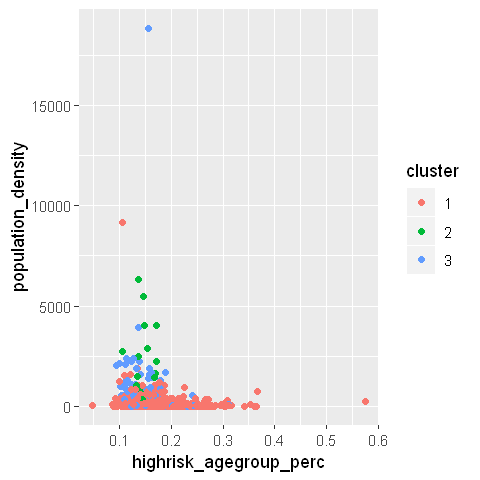

Saving 6.67 x 6.67 in image


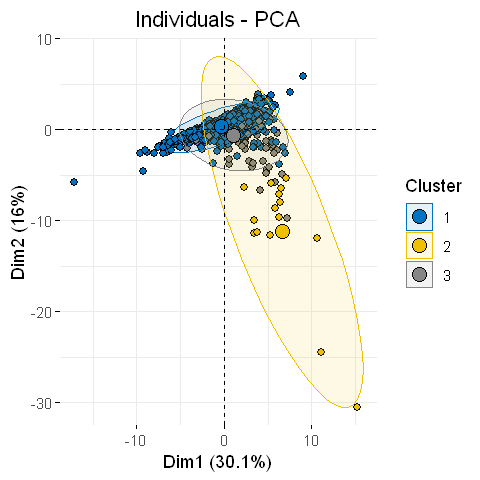

In [174]:
# k means
# k = 3

selected_column_indices <- c(4:8,11:16)
num_clusters <- 3 #try some number

jail_county_demographics_filtered_df_dropna <- drop_na(jail_county_demographics_filtered_df)

#opt_k <- fviz_nbclust(jail_county_demographics_filtered_df_dropna[ , selected_column_indices], kmeans, method = "gap_stat")

set.seed(42)
km <- kmeans(scale(jail_county_demographics_filtered_df_dropna[ , selected_column_indices]), num_clusters )
jail_county_demographics_filtered_df_dropna$cluster <- as.factor(km$cluster)
#write.csv(jail_county_demographics_filtered_df_dropna, 'jail_county_demographics_clustered_4means.csv', row.names=FALSE)


# get a sense of the clusters
options(repr.plot.width=4)
ggplot(jail_county_demographics_filtered_df_dropna, 
       aes( x = highrisk_agegroup_perc, y = population_density, color = cluster) ) + 
            geom_point()

jail_county_demographics_filtered_df_dropna %>%
    group_by( cluster ) %>%
    summarize( count = n(),
             ave_incarceration_rate = mean(jail_incarceration_rate_per_100k),
             ave_jail_pop = mean(jail_population),
             ave_res_pop = mean(resident_population),
             ave_highrisk_agegroup_perc = mean(highrisk_agegroup_perc))

jail_county_demographics_filtered_df_dropna %>%
    group_by( cluster, urbanicity ) %>%
    summarize( count = n(),
             ave_incarceration_rate = mean(jail_incarceration_rate_per_100k),
             ave_res_pop = mean(resident_population),
             ave_highrisk_agegroup_perc = mean(highrisk_agegroup_perc))

# pca to see clusters
#pca
data <- jail_county_demographics_filtered_df_dropna
selected_column_indices <- c(4:8,10:31)

pca <- prcomp(data[ , selected_column_indices], center = TRUE, scale = TRUE)
summary(pca)

# principal components + clusters
plot <- fviz_pca_ind(pca, geom.ind = "point", pointshape = 21, 
             pointsize = 2, 
             fill.ind = data$cluster, 
             col.ind = "black", 
             palette = "jco", 
             addEllipses = TRUE,
             label = "var",
             col.var = "black",
             repel = TRUE,
             legend.title = "Cluster") +
  theme(plot.title = element_text(hjust = 0.5))
plot 
#ggsave('3clusterpca.png', plot)

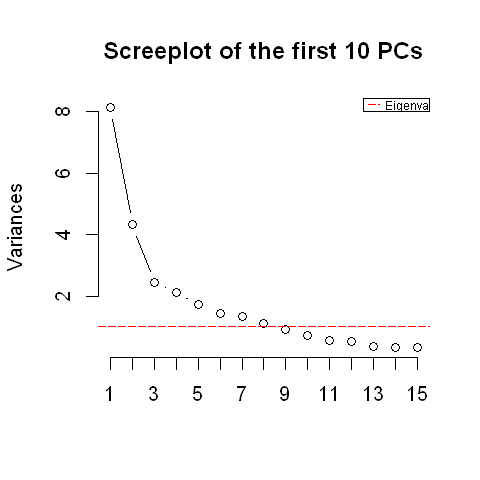

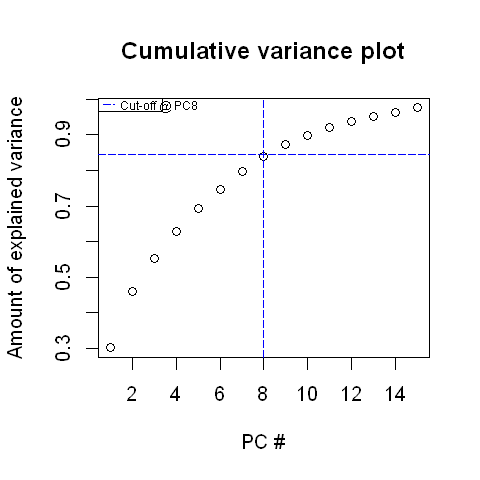

In [169]:
# more on pca

# initial plots
#plot(pca$x[,1],pca$x[,2], xlab="PC1 (29.9%)", ylab = "PC2 (17.8%)", main = "PC1 / PC2 - plot")

#scree plots
screeplot(pca, type = "l", npcs = 15, main = "Screeplot of the first 10 PCs")
abline(h = 1, col="red", lty=5)
legend("topright", legend=c("Eigenvalue = 1"),
       col=c("red"), lty=5, cex=0.6)
cumpro <- cumsum(pca$sdev^2 / sum(pca$sdev^2))
plot(cumpro[0:15], xlab = "PC #", ylab = "Amount of explained variance", main = "Cumulative variance plot")
abline(v = 8, col="blue", lty=5)
abline(h = 0.845, col="blue", lty=5)
legend("topleft", legend=c("Cut-off @ PC8"),
       col=c("blue"), lty=5, cex=0.6)

cluster,count,ave_incarceration_rate,ave_jail_pop,ave_res_pop,ave_highrisk_agegroup_perc
1,140,181.59143,82.97857,46244.93,0.2548209
2,266,212.91842,410.70301,263109.65,0.1341650
3,553,268.90235,145.97288,78645.64,0.1831813
4,12,83.33333,2955.75000,2956303.75,0.1471266


cluster,urbanicity,count,ave_incarceration_rate,ave_res_pop,ave_highrisk_agegroup_perc
1,rural,109,175.86514,29229.49,0.2510332
1,small/mid,25,213.82000,103033.60,0.2774696
1,suburban,6,151.33333,118739.33,0.2292599
2,rural,93,246.89355,31421.99,0.1396095
2,small/mid,99,232.82020,232453.48,0.1337359
2,suburban,57,149.48947,356095.05,0.1281207
2,urban,17,123.82941,1397330.00,0.1271446
3,rural,298,311.69765,33007.04,0.1873470
3,small/mid,178,218.37135,121223.43,0.1815814
3,suburban,75,223.31733,132565.63,0.1703980


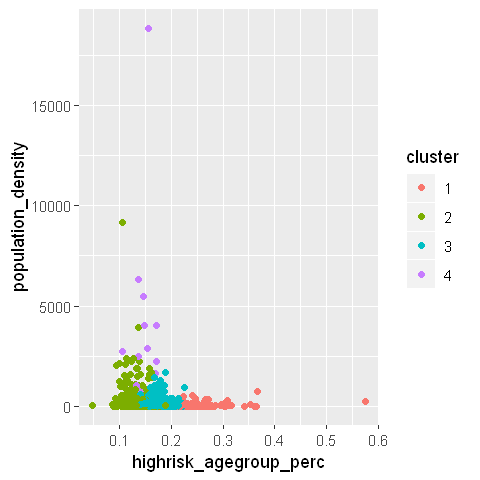

Saving 6.67 x 6.67 in image


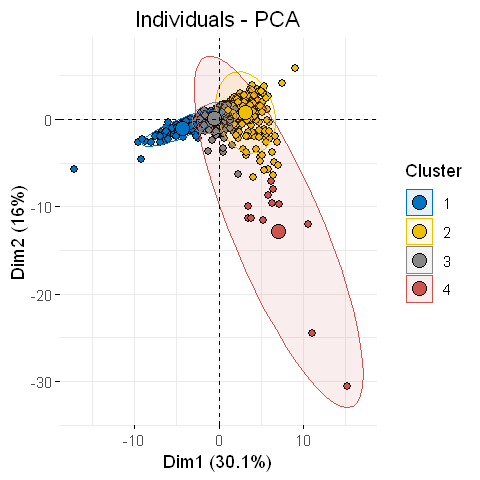

In [175]:
# k = 4

selected_column_indices <- c(4:8,10:31)
num_clusters <- 4 #try some number

jail_county_demographics_filtered_df_dropna <- drop_na(jail_county_demographics_filtered_df)

#opt_k <- fviz_nbclust(jail_county_demographics_filtered_df_dropna[ , selected_column_indices], kmeans, method = "gap_stat")

set.seed(42)
km <- kmeans(scale(jail_county_demographics_filtered_df_dropna[ , selected_column_indices]), num_clusters )
jail_county_demographics_filtered_df_dropna$cluster <- as.factor(km$cluster)
#write.csv(jail_county_demographics_filtered_df_dropna, 'jail_county_demographics_clustered_4means.csv', row.names=FALSE)


# get a sense of the clusters
options(repr.plot.width=4)
ggplot(jail_county_demographics_filtered_df_dropna, 
       aes( x = highrisk_agegroup_perc, y = population_density, color = cluster) ) + 
            geom_point()

jail_county_demographics_filtered_df_dropna %>%
    group_by( cluster ) %>%
    summarize( count = n(),
             ave_incarceration_rate = mean(jail_incarceration_rate_per_100k),
             ave_jail_pop = mean(jail_population),
             ave_res_pop = mean(resident_population),
             ave_highrisk_agegroup_perc = mean(highrisk_agegroup_perc))

jail_county_demographics_filtered_df_dropna %>%
    group_by( cluster, urbanicity ) %>%
    summarize( count = n(),
             ave_incarceration_rate = mean(jail_incarceration_rate_per_100k),
             ave_res_pop = mean(resident_population),
             ave_highrisk_agegroup_perc = mean(highrisk_agegroup_perc))

#pca
data <- jail_county_demographics_filtered_df_dropna
#pca <- prcomp(data[ , selected_column_indices], center = TRUE, scale = TRUE)
#summary(pca)

# principal components + clusters
plot <- fviz_pca_ind(pca, geom.ind = "point", pointshape = 21, 
             pointsize = 2, 
             fill.ind = data$cluster, 
             col.ind = "black", 
             palette = "jco", 
             addEllipses = TRUE,
             label = "var",
             col.var = "black",
             repel = TRUE,
             legend.title = "Cluster") +
  theme(plot.title = element_text(hjust = 0.5))
plot
#ggsave('4clusterpca.png', plot)

cluster,count,ave_incarceration_rate,ave_jail_pop,ave_res_pop,ave_highrisk_agegroup_perc
1,120,184.5675,86.18333,46187.58,0.2603560
2,184,197.1266,659.78804,486663.04,0.1309805
3,493,252.4696,134.15822,75804.13,0.1843947
4,129,290.5512,271.24031,162970.09,0.1700520
5,45,253.2022,92.95556,43223.38,0.1386927


cluster,urbanicity,count,ave_incarceration_rate,ave_res_pop,ave_highrisk_agegroup_perc
1,rural,95,174.1716,30553.86,0.2552742
1,small/mid,22,228.7727,115593.41,0.2848198
1,suburban,3,189.6000,32279.33,0.2418810
2,rural,49,279.5510,31113.78,0.1346878
2,small/mid,65,201.3646,268930.57,0.1317168
2,suburban,47,144.4170,380720.91,0.1270597
2,urban,23,117.2609,2289002.39,0.1290134
3,rural,268,291.0119,33560.56,0.1888251
3,small/mid,154,204.3818,122185.14,0.1821204
3,suburban,70,212.2943,119209.30,0.1723691


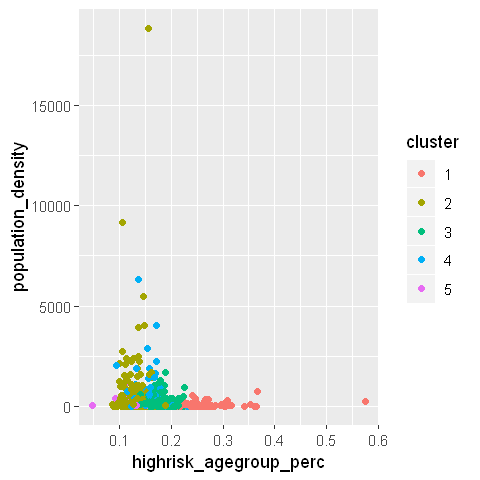

Saving 6.67 x 6.67 in image


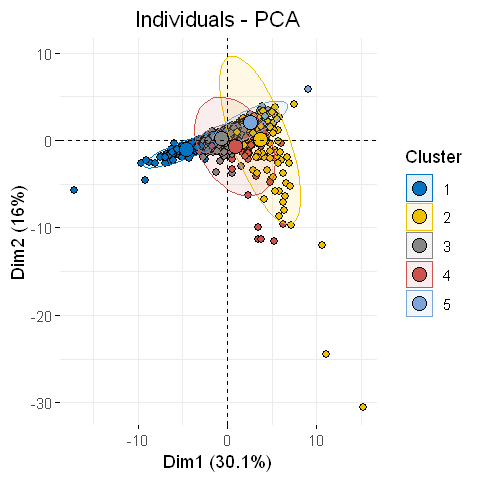

In [176]:
# k = 5

selected_column_indices <- c(4:8,10:31)
num_clusters <- 5 

jail_county_demographics_filtered_df_dropna <- drop_na(jail_county_demographics_filtered_df)

set.seed(42)
km <- kmeans(scale(jail_county_demographics_filtered_df_dropna[ , selected_column_indices]), num_clusters )
jail_county_demographics_filtered_df_dropna$cluster <- as.factor(km$cluster)
#write.csv(jail_county_demographics_filtered_df_dropna, 'jail_county_demographics_clustered_4means.csv', row.names=FALSE)


# get a sense of the clusters
options(repr.plot.width=4)
ggplot(jail_county_demographics_filtered_df_dropna, 
       aes( x = highrisk_agegroup_perc, y = population_density, color = cluster) ) + 
            geom_point()

jail_county_demographics_filtered_df_dropna %>%
    group_by( cluster ) %>%
    summarize( count = n(),
             ave_incarceration_rate = mean(jail_incarceration_rate_per_100k),
             ave_jail_pop = mean(jail_population),
             ave_res_pop = mean(resident_population),
             ave_highrisk_agegroup_perc = mean(highrisk_agegroup_perc))

jail_county_demographics_filtered_df_dropna %>%
    group_by( cluster, urbanicity ) %>%
    summarize( count = n(),
             ave_incarceration_rate = mean(jail_incarceration_rate_per_100k),
             ave_res_pop = mean(resident_population),
             ave_highrisk_agegroup_perc = mean(highrisk_agegroup_perc))

#pca
data <- jail_county_demographics_filtered_df_dropna
#pca <- prcomp(data[ , selected_column_indices], center = TRUE, scale = TRUE)

# principal components + clusters
plot <- fviz_pca_ind(pca, geom.ind = "point", pointshape = 21, 
             pointsize = 2, 
             fill.ind = data$cluster, 
             col.ind = "black", 
             palette = "jco", 
             addEllipses = TRUE,
             label = "var",
             col.var = "black",
             repel = TRUE,
             legend.title = "Cluster") +
  theme(plot.title = element_text(hjust = 0.5))
plot
#ggsave('5clusterpca.png', plot)

In [172]:
# find optimal number of clusters
opt_k <- fviz_nbclust(jail_county_demographics_filtered_df_dropna[ , selected_column_indices], kmeans, method = "gap_stat")

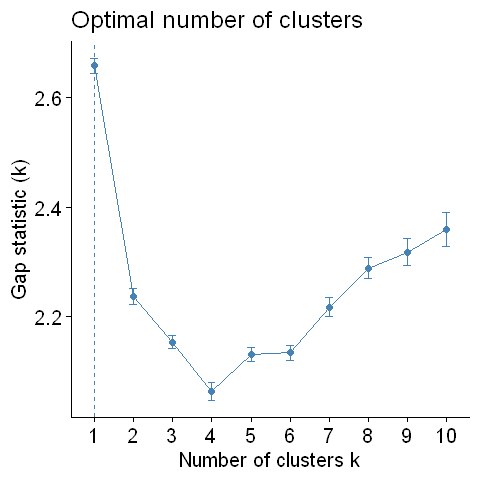

In [173]:
opt_k

GLM on each cluster (k = ?)

In [ ]:
#glm(formula, family = gaussian, data, weights, subse )